In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import datetime

from btgym import BTgymDataset

from logbook import WARNING, INFO, DEBUG


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')


import unittest

### Data sampling consistency test


In [6]:


num_tests = 1000

filename='./data/CRYPTO_M1_201809_biased_1e-5.csv'

parsing_params = dict(
    # CSV to Pandas params.
    sep=',',
    header=0,
    index_col=0,
    parse_dates=True,
    names=['open'],

    # Pandas to BT.feeds params:
    timeframe=1,  # 1 minute.
    datetime=0,
    open=1,
    high=-1,
    low=-1,
    close=-1,
    volume=-1,
    openinterest=-1,
)

class DomainTest(unittest.TestCase):

    def test_BTgymDataset_sampling_bounds_consistency(self):
        """
        Any train trial mast precede any test period.
        Same true for train/test episodes.
        """
        domain = BTgymDataset(
            filename=filename,
            episode_duration={'days': 0, 'hours': 22, 'minutes': 0},
            time_gap={'days': 0, 'hours': 12},
            start_00=False,
            start_weekdays={0, 1, 2, 3, 4, 5, 6},
            parsing_params=parsing_params,
            target_period={'days': 1, 'hours': 0, 'minutes': 0},
        )
        domain.reset()
        sup_train_time = 0
        inf_test_time = domain.data[-2:-1].index[0].value
        
        sup_test_index = None
        sup_test_time = 0
        
        train_starts = []
        train_ends = []
        test_starts = []
        test_ends = []
                
        for i in range(num_tests):
            train_trial = domain.sample(get_new=True, sample_type=0)
            last_train_time = train_trial.data[-2:-1].index[0].value
            if last_train_time > sup_train_time:
                sup_train_time = last_train_time

            test_trial = domain.sample(get_new=True, sample_type=1)
            first_test_time = test_trial.data[0:1].index[0].value
            if first_test_time < inf_test_time:
                inf_test_time = first_test_time

            with self.subTest(msg='sub_{}'.format(i), train_trial=train_trial.filename, test_trial=test_trial.filename):
                self.assertLess(sup_train_time, inf_test_time)
                #print('sup_train_time: {}, inf_test_time: {}'.format(sup_train_time, inf_test_time))
                with self.subTest('Train/test should be irrelevant dor Dataset episodes'):
                    train_trial.reset()
                    test_trial.reset()
                    episode_1 = test_trial.sample(get_new=True, sample_type=1)
                    episode_2 = train_trial.sample(get_new=True, sample_type=1)
                    

                    if sup_test_time < episode_1.data[-2:-1].index[0].value:
                        sup_test_index = episode_1.data[-2:-1].index[0]
                    
                    
                    train_starts.append(episode_2.data[0:1].index[0])
                    train_ends.append(episode_2.data[-2:-1].index[0])


                    test_starts.append(episode_1.data[0:1].index[0])
                    test_ends.append(episode_1.data[-2:-1].index[0])

                    
        print('sup_test_index: ', sup_test_index)
        
        plt.figure(num=4, figsize=(14, 8))
        plt.title('Episodes times distribution')
        
        plt.hist(train_starts, bins=50, label='train episode start time')
        plt.hist(train_ends,  bins=50, label='train episode end time')
        plt.hist(test_starts,  bins=50, label='test episode start time')
        plt.hist(test_ends,  bins=50, label='test episode end time')

        plt.grid(True)
        plt.legend()
        

sup_test_index:  2018-09-21 23:50:00


.
----------------------------------------------------------------------
Ran 1 test in 12.164s

OK


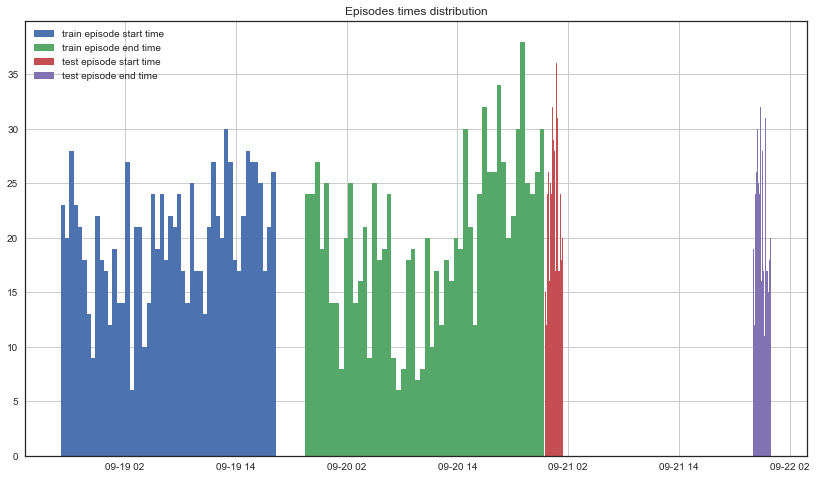

In [7]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)